In [27]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import yfinance as yf
import os

def fetch_eia_data(filename, start_date, end_date):
    df = pd.read_excel(filename, sheet_name=1, skiprows=2)

    if not pd.api.types.is_datetime64_any_dtype(df['Date']):
        df['Date'] = pd.to_datetime(df['Date'], format='%b %d, %Y')

    df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
    return df

In [28]:
from google.colab import drive

#drive.mount("/content/drive")
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [29]:
start_date = '2010-11-18'
end_date = '2020-09-18'

DATA_DIR = os.path.join("drive", "MyDrive", "data")
DATASET_EIA = os.path.join(DATA_DIR, "RNGWHHDd.xls")

# Fetch Natural Gas Spot Prices
natural_gas_prices = fetch_eia_data(DATASET_EIA, start_date, end_date)

# Using Yahoo Finance as a fallback for natural gas prices
natural_gas_yf = yf.download('NG=F', start=start_date, end=end_date)['Adj Close']
df = pd.DataFrame(natural_gas_yf).rename(columns={'Adj Close': 'Natural_Gas_Spot_Price'})

# Fetch additional economic variables using Yahoo Finance and FRED
indices = {
    '^GSPC': 'S&P 500',
    '^DJI': 'Dow Jones Industrial Average',
    'EURUSD=X': 'EUR/USD Exchange Rate',
    'NASDAQCOM': 'NASDAQ Composite',
    'DEXJPUS': 'JPY/USD',
    'DEXUSUK': 'USD/GBP',
    'DCOILWTICO': 'WTI Spot Price',
    'FEDFUNDS': 'Federal Funds Rate',
    'T5YIE': '5-Year Breakeven Inflation Rate',
    'T10YIE': '10-Year Breakeven Inflation Rate',
    'GS1': '1-Year Treasury Rate',
    'GS10': '10-Year Treasury Rate',
    'MPRIME': 'Prime Rate'
}

# Fetch from Yahoo Finance
for index, name in indices.items():
    if index.startswith('^') or index.endswith('=X'):
        df[name] = yf.download(index, start=start_date, end=end_date)['Adj Close']

# Fetch from FRED
for index, name in indices.items():
    if not (index.startswith('^') or index.endswith('=X')):
        df[name] = web.DataReader(index, 'fred', start_date, end_date)

# Calculating Momentum and Moving Averages
df['Momentum_5'] = df['Natural_Gas_Spot_Price'].rolling(window=5).apply(lambda x: (np.diff(x) > 0).sum(), raw=True)
df['Momentum_10'] = df['Natural_Gas_Spot_Price'].rolling(window=10).apply(lambda x: (np.diff(x) > 0).sum(), raw=True)
df['MA_5'] = df['Natural_Gas_Spot_Price'].rolling(window=5).mean()
df['MA_10'] = df['Natural_Gas_Spot_Price'].rolling(window=10).mean()

# Applying natural logarithm to all columns except interest rates
for column in df.columns:
    if 'Rate' not in column:
        df[column] = np.log(df[column])

# Handling any infinities or NaNs that arise from logarithmic transformation or empty data points
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.ffill(inplace=True)  # Forward fill

df = df.iloc[10:]
# Export to CSV
df.to_csv(os.path.join(DATA_DIR, 'compiled_dataset.csv'), index=True)

print("Dataset compiled and saved to 'compiled_dataset.csv'.")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Dataset compiled and saved to 'compiled_dataset.csv'.


In [30]:
# In order to test the generalization ability of the trained models
# the dataset was divided into two parts: the first 90% was used
# as the training data set (in-sample, consisting of 2180 observations),
# and the remaining 10% of the most recent observations was the test data set
# (out-of-sample, consisting of 243 observations).

train_size = int(0.9 * len(df))
df_train = df.iloc[:train_size]
df_test = df.iloc[train_size:]

## Identify best AR(q) model

In [31]:
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, learning_curve
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, Matern, ExpSineSquared
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler



Optimal number of lags: 10, In-sample RMSE: 0.0397


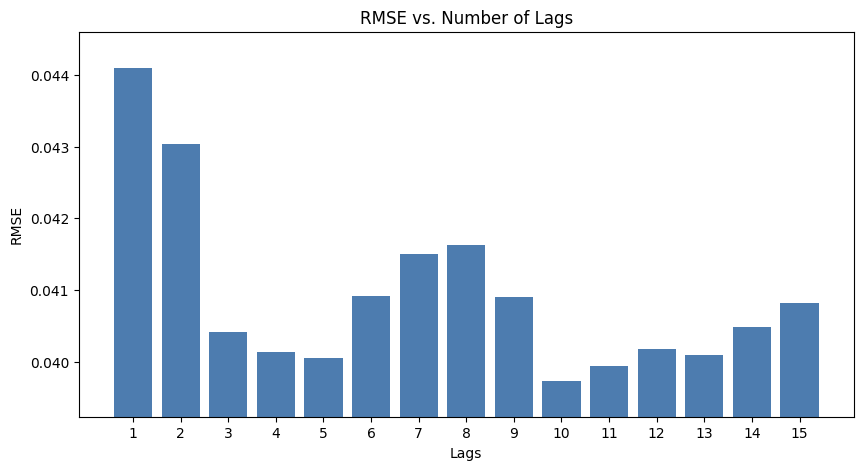

In [32]:
rmse_values = []
min_rmse = float('inf')
optimal_lags = 0

for q in range(1, 16):
    df_train_temp = df_train.copy()
    df_test_temp = df_test.copy()

    for lag in range(1, q + 1):
        df_train_temp[f'lag_{lag}'] = df_train_temp['Natural_Gas_Spot_Price'].shift(lag)
        df_test_temp[f'lag_{lag}'] = df_test_temp['Natural_Gas_Spot_Price'].shift(lag)

    df_train_lagged = df_train_temp.dropna()
    df_test_lagged = df_test_temp.dropna()

    X_train = df_train_lagged[[f'lag_{lag}' for lag in range(1, q + 1)]]
    y_train = df_train_lagged['Natural_Gas_Spot_Price']
    X_test = df_test_lagged[[f'lag_{lag}' for lag in range(1, q + 1)]]
    y_test = df_test_lagged['Natural_Gas_Spot_Price']

    svm_model = SVR(kernel='linear')
    svm_model.fit(X_train, y_train)
    y_pred_test = svm_model.predict(X_test)

    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    rmse_values.append(test_rmse)

    if test_rmse < min_rmse:
        min_rmse = test_rmse
        optimal_lags = q

print(f"Optimal number of lags: {optimal_lags}, In-sample RMSE: {min_rmse:.4f}")
import matplotlib.pyplot as plt

lags = range(1, 16)

plt.figure(figsize=(10, 5))
plt.bar(lags, rmse_values, color='#4d7caf')
plt.xlabel('Lags')
plt.ylabel('RMSE')
plt.title('RMSE vs. Number of Lags')
plt.xticks(lags)
plt.ylim([min(rmse_values) - 0.0005, max(rmse_values) + 0.0005])

plt.show()

# Models setup

### Time Frame t + 1

In [33]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    'Random Walk': None,
    'Linear Regression': LinearRegression(),
    'Robust Linear Regression': HuberRegressor(max_iter=1000),
    'SVM Linear': SVR(kernel='linear'),
    'SVM Quadratic': SVR(kernel='poly', degree=2),
    'SVM Cubic': SVR(kernel='poly', degree=3),
    'SVM Gaussian Fine': SVR(kernel='rbf', gamma='scale'),
    'SVM Gaussian Medium': SVR(kernel='rbf', gamma='auto'),
    'SVM Gaussian Coarse': SVR(kernel='rbf', gamma=0.1),
    'GPR Rational Quadratic': GaussianProcessRegressor(kernel=RationalQuadratic(), alpha=1e-5),
    'GPR Squared Exponential': GaussianProcessRegressor(kernel=RBF(), alpha=1e-5),
    'GPR Matern 5/2': GaussianProcessRegressor(kernel=Matern(nu=2.5), alpha=1e-5),
    'Fine Tree': DecisionTreeRegressor(max_depth=5),
    'Medium Tree': DecisionTreeRegressor(max_depth=10),
    'Coarse Tree': DecisionTreeRegressor(max_depth=15),
    'Bagged Trees': BaggingRegressor(),
    'Boosted Trees': GradientBoostingRegressor()
}

def rmse_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse_score, greater_is_better=False)

model_results = []
for name, model in models.items():
    if model is not None:
        try:
            scores = cross_val_score(model, X_train_scaled, y_train, cv=TimeSeriesSplit(n_splits=5), scoring=rmse_scorer)
            in_sample_rmse = -scores.mean()

            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            out_sample_rmse = rmse_score(y_test, y_pred)


            model_results.append({
                'Model': name,
                'In-Sample RMSE': in_sample_rmse,
                'OOS RMSE': out_sample_rmse,
            })
        except Exception as e:
            model_results.append({
                'Model': name,
                'In-Sample RMSE': str(e),
                'OOS RMSE': 'Error',
            })
    else:
        if name == 'Random Walk':
            y_pred = np.roll(y_train, 1)
            y_pred[0] = y_train[0]
            in_sample_rmse = rmse_score(y_train, y_pred)
            y_pred_test = np.roll(y_test, 1)
            y_pred_test[0] = y_test[0]
            out_sample_rmse = rmse_score(y_test, y_pred_test)
            model_results.append({
                'Model': name,
                'In-Sample RMSE': in_sample_rmse,
                'OOS RMSE': out_sample_rmse,
            })

results_df = pd.DataFrame(model_results)
print(results_df)


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


                       Model  In-Sample RMSE  OOS RMSE
0                Random Walk        0.027760  0.037453
1          Linear Regression        0.028311  0.037846
2   Robust Linear Regression        0.028362  0.037749
3                 SVM Linear        0.035434  0.042589
4              SVM Quadratic        0.240767  0.887438
5                  SVM Cubic        0.155564  0.479414
6          SVM Gaussian Fine        0.070022  0.086526
7        SVM Gaussian Medium        0.067316  0.086526
8        SVM Gaussian Coarse        0.073952  0.100409
9     GPR Rational Quadratic        0.059142  0.070611
10   GPR Squared Exponential        0.141012  0.139381
11            GPR Matern 5/2        0.082988  0.074406
12                 Fine Tree        0.040693  0.046124
13               Medium Tree        0.047888  0.056270
14               Coarse Tree        0.049136  0.055096
15              Bagged Trees        0.040578  0.042216
16             Boosted Trees        0.038850  0.041897


In [34]:
import matplotlib.pyplot as plt

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        axes = plt.gca()
    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    try:
        train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
            estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,
            return_times=True, scoring='neg_root_mean_squared_error')
        train_scores_mean = -np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = -np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        max_score = max(max(train_scores_mean), max(test_scores_mean))
        axes.set_ylim(0, max_score + 0.1 * max_score)

        axes.grid()
        axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                          train_scores_mean + train_scores_std, alpha=0.1, color="r")
        axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                          test_scores_mean + test_scores_std, alpha=0.1, color="g")
        axes.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
        axes.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

        axes.legend(loc="best")
    except Exception as e:
        print(f"Error plotting {title}: {str(e)}")

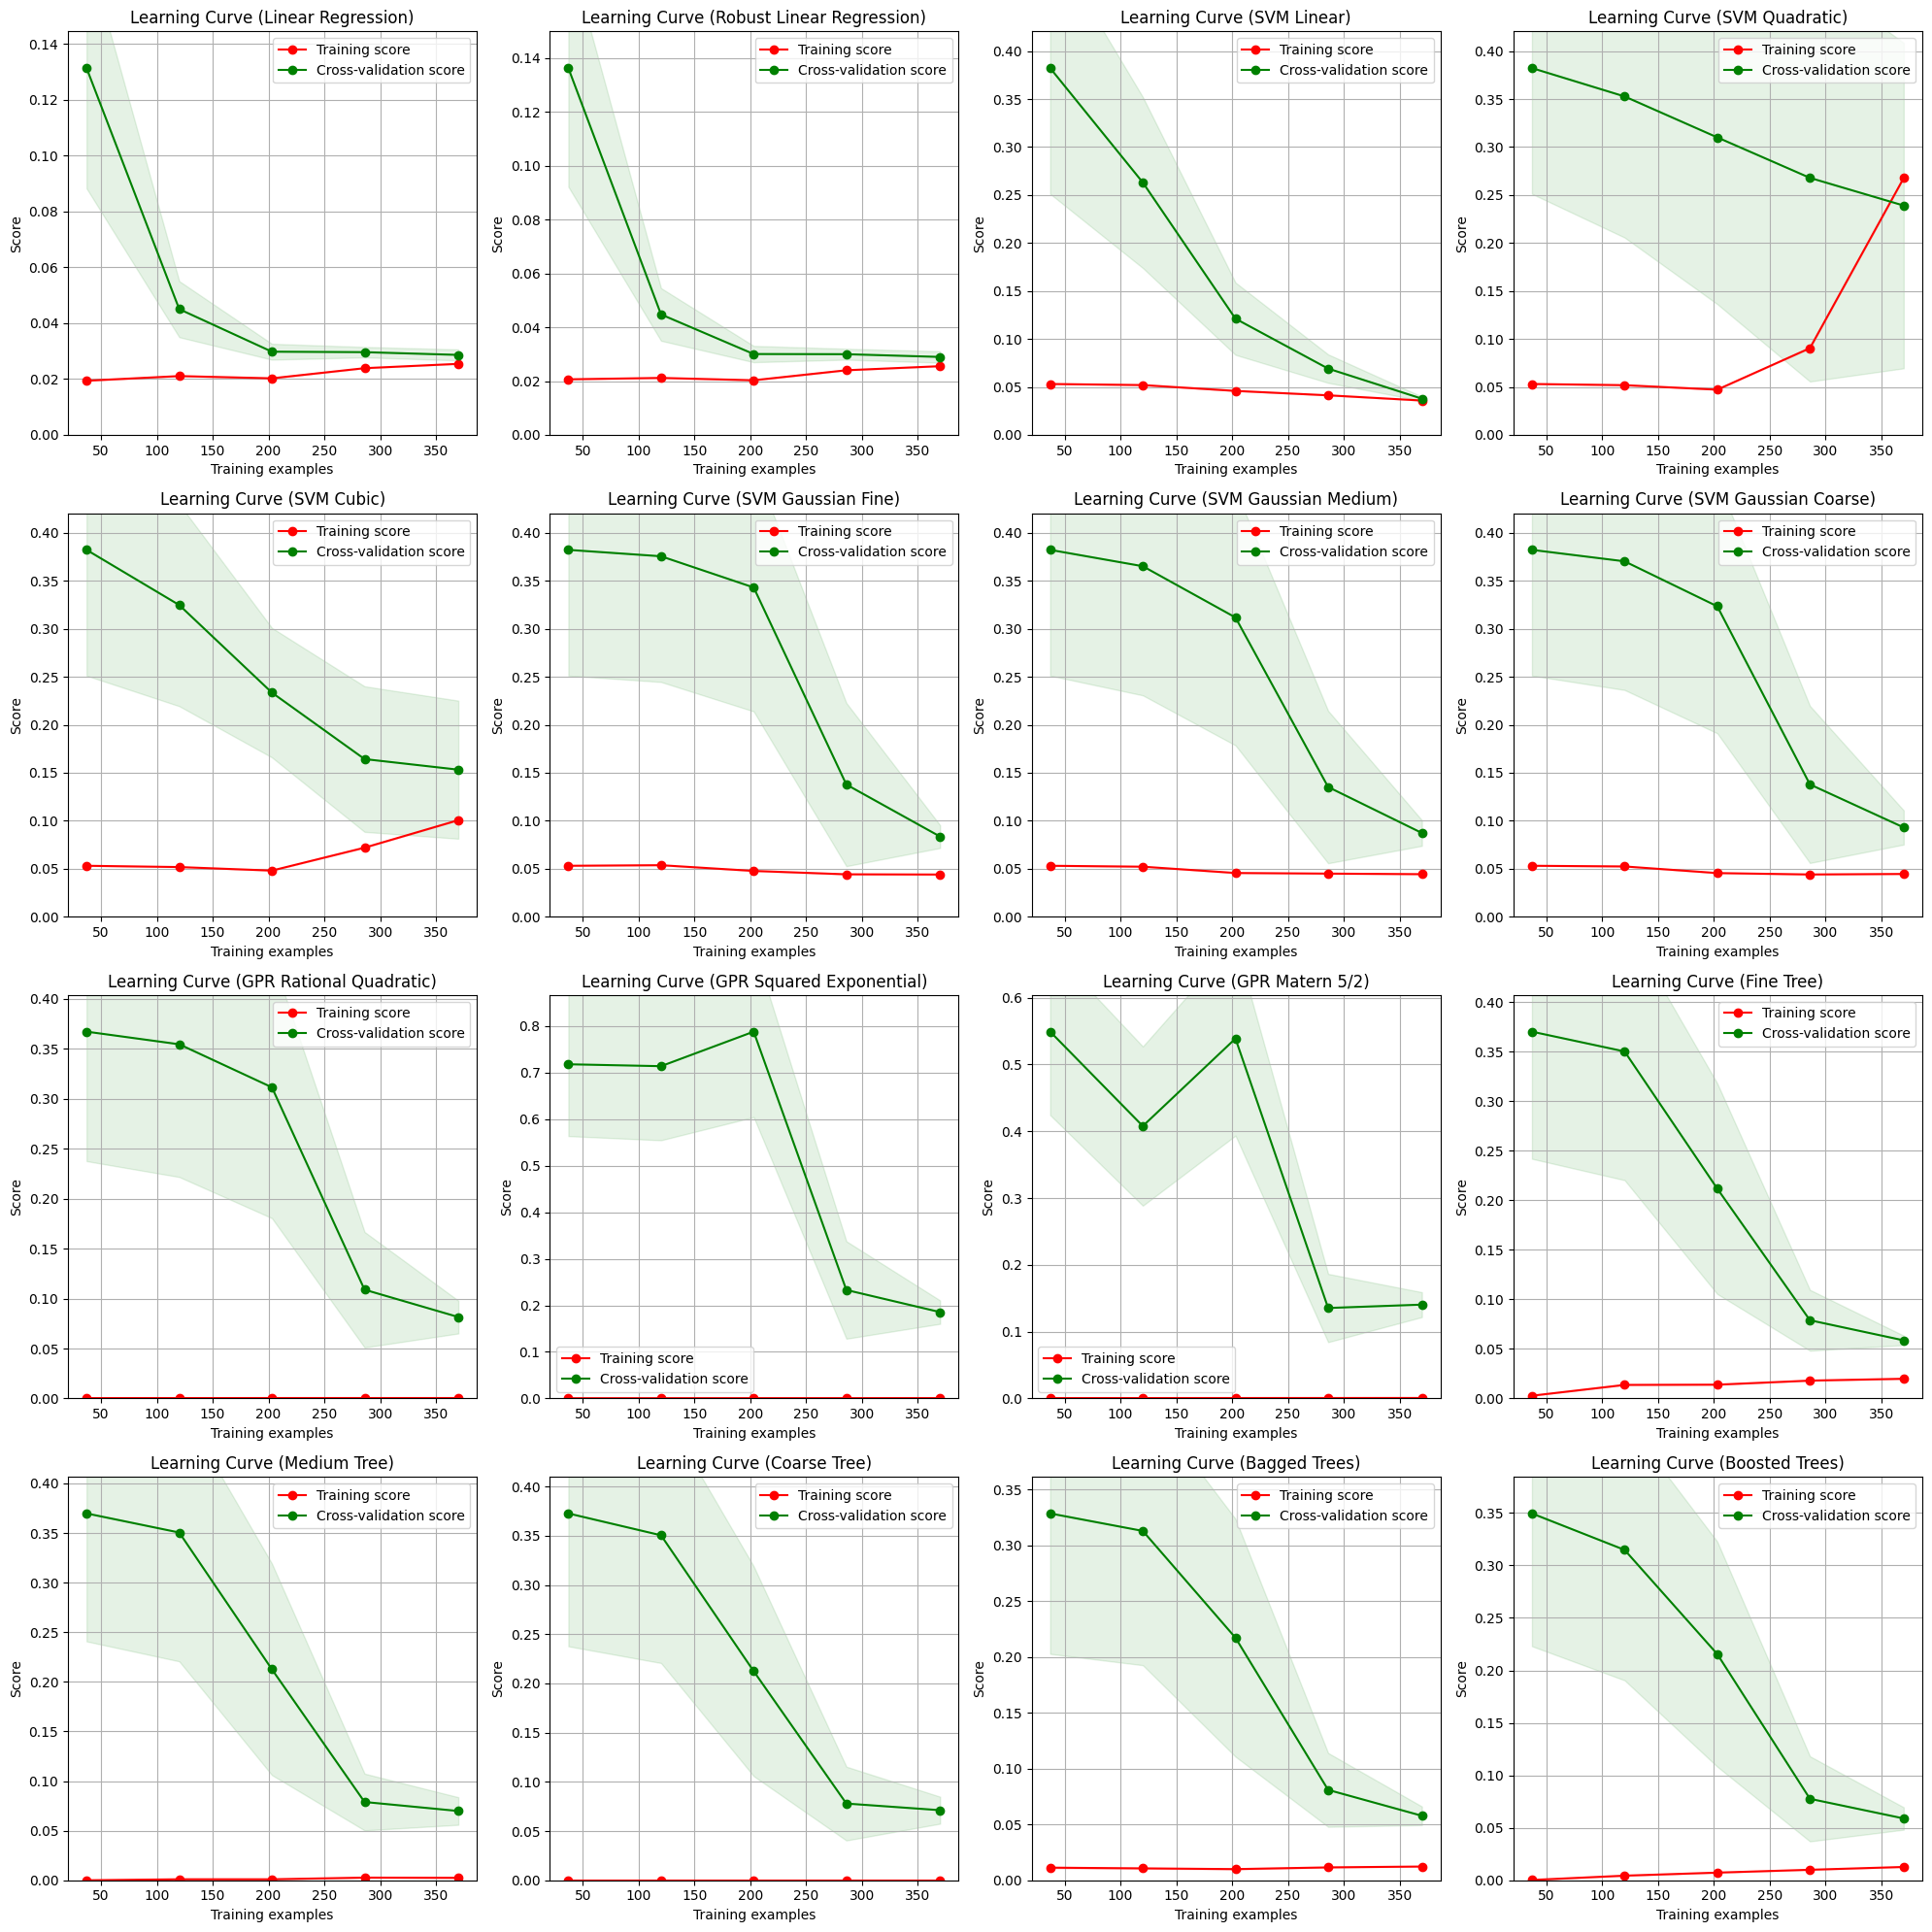

In [35]:
num_rows = 4
num_cols = 4
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 20))
model_iter = iter(models.items())
next(model_iter) # Skip the first model (Random Walk)


for i, (name, model) in enumerate(model_iter):
    if model is None:
        continue

    ax = axes[i // num_cols, i % num_cols]
    plot_learning_curve(model, f'Learning Curve ({name})', X_train_scaled, y_train,
                        axes=ax, ylim=(0, 1), cv=TimeSeriesSplit(n_splits=5), n_jobs=4)

plt.tight_layout()
plt.show()

In [36]:
remaining_models = [
    'Random Walk',
    'Linear Regression',
    'Robust Linear Regression',
    'Fine Tree',
    'Medium Tree',
    'Coarse Tree',
    'SVM Linear',
    'Bagged Trees',
    'Boosted Trees'
]

models = {
    'Random Walk': None,
    'Linear Regression': LinearRegression(),
    'Robust Linear Regression': HuberRegressor(max_iter=1000),
    'Fine Tree': DecisionTreeRegressor(max_depth=5),
    'Medium Tree': DecisionTreeRegressor(max_depth=10),
    'Coarse Tree': DecisionTreeRegressor(max_depth=15),
    'SVM Linear': SVR(kernel='linear'),
    'Bagged Trees': BaggingRegressor(),
    'Boosted Trees': GradientBoostingRegressor()
}

filtered_df = results_df[results_df['Model'].isin(remaining_models)]

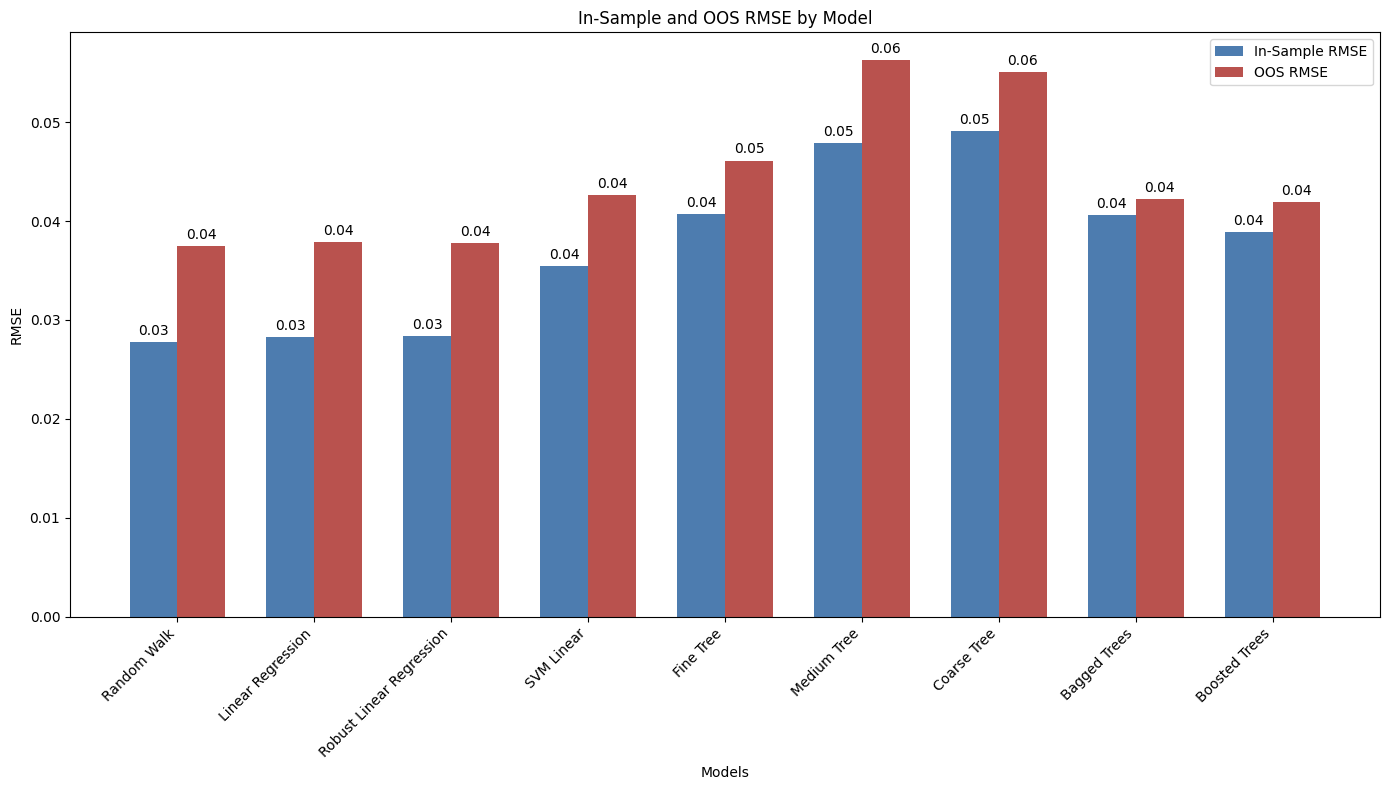

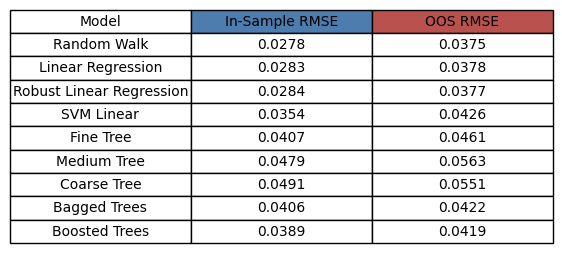

In [37]:
x = np.arange(len(filtered_df['Model']))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 8))
rects1 = ax.bar(x - width/2, filtered_df['In-Sample RMSE'], width, label='In-Sample RMSE', color='#4d7caf')
rects2 = ax.bar(x + width/2, filtered_df['OOS RMSE'], width, label='OOS RMSE', color='#b9524e')

ax.set_xlabel('Models')
ax.set_ylabel('RMSE')
ax.set_title('In-Sample and OOS RMSE by Model')
ax.set_xticks(x)
ax.set_xticklabels(filtered_df['Model'], rotation=45, ha="right")
ax.legend()

for rect in rects1:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

for rect in rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

filtered_df = filtered_df.applymap(lambda x: round(x, 4) if isinstance(x, (float, int)) else x)

fig, ax = plt.subplots(figsize=(7, 1))
ax.axis('tight')
ax.axis('off')

the_table = ax.table(cellText=filtered_df.values, colLabels=filtered_df.columns, loc='center', cellLoc='center', colColours=['none', '#4d7caf', '#b9524e'])

the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
the_table.scale(1, 1.4)

plt.show()

In [38]:
results_df = results_df.iloc[1:]

best_model_in_sample = results_df.loc[results_df['OOS RMSE'].idxmin(), 'Model']
print(f"Best model for In-Sample RMSE: {best_model_in_sample}")

best_model_out_of_sample = results_df.loc[results_df['In-Sample RMSE'].idxmin(), 'Model']
print(f"Best model for OOS RMSE: {best_model_out_of_sample}")

Best model for In-Sample RMSE: Robust Linear Regression
Best model for OOS RMSE: Linear Regression


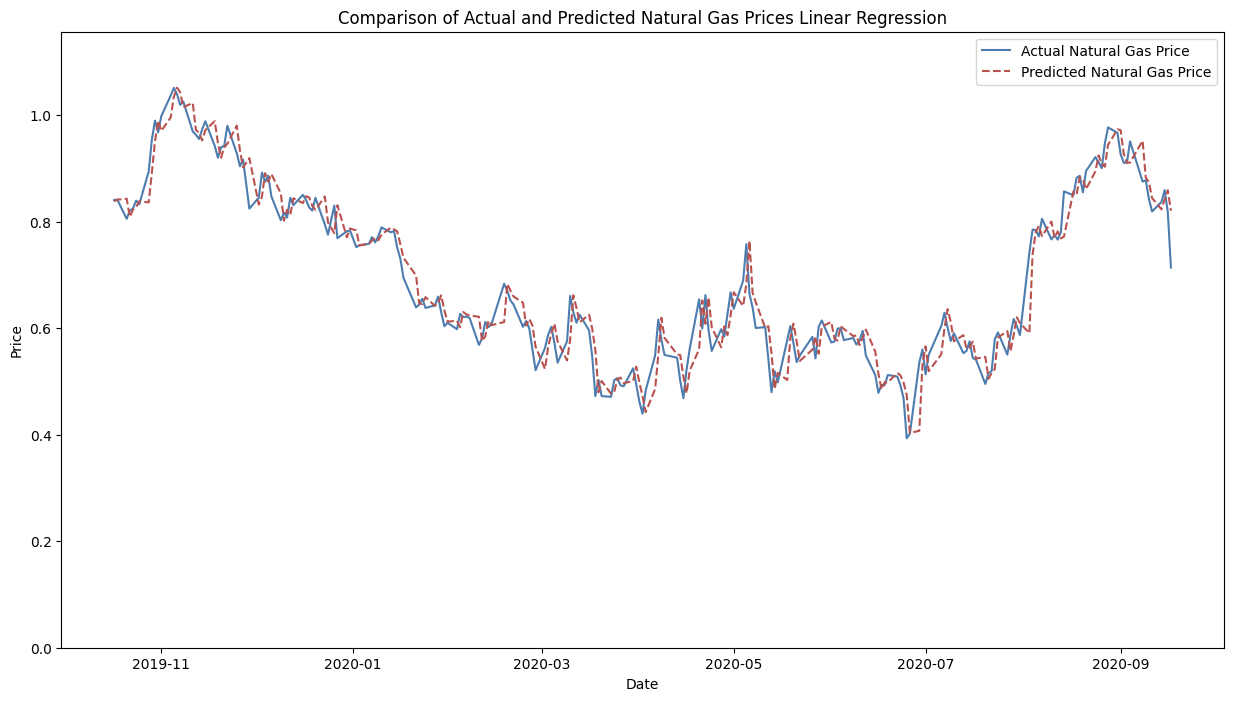

In [39]:
model = models[best_model_out_of_sample]
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

plt.figure(figsize=(15, 8))
plt.plot(y_test.index, y_test, label='Actual Natural Gas Price', color="#4d7caf")
plt.plot(y_test.index, y_pred, label='Predicted Natural Gas Price', color="#b9524e", linestyle='--')
plt.title(f'Comparison of Actual and Predicted Natural Gas Prices {best_model_out_of_sample}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.ylim([0, max(y_test.max(), y_pred.max()) * 1.1])

plt.legend()
plt.show()


### Time Frames t + 3, t + 5, t + 10

In [40]:
def prepare_data(X, y, shift):
    """
    Prepare data for time series forecasting by shifting the target variable.
    Adjusts X and y to the same length after shifting.
    """
    y_shifted = y[shift:]

    X_shifted = X[shift:shift + len(y_shifted)]

    min_length = min(len(X_shifted), len(y_shifted))
    X_shifted = X_shifted[:min_length]
    y_shifted = y_shifted[:min_length]

    return X_shifted, y_shifted


In-Sample RMSE Scores in Ascending Order:
                      Model  In-Sample RMSE
1         Linear Regression        0.028313
2  Robust Linear Regression        0.028365
6                SVM Linear        0.035434
8             Boosted Trees        0.038588
7              Bagged Trees        0.040160
3                 Fine Tree        0.043018
0               Random Walk        0.046381
5               Coarse Tree        0.048733
4               Medium Tree        0.050733

Out-of-Sample RMSE Scores in Ascending Order:
                      Model  Out-of-Sample RMSE
2  Robust Linear Regression            0.037907
1         Linear Regression            0.038010
6                SVM Linear            0.042803
8             Boosted Trees            0.042880
7              Bagged Trees            0.044958
3                 Fine Tree            0.046384
4               Medium Tree            0.054876
5               Coarse Tree            0.055263
0               Random Walk           

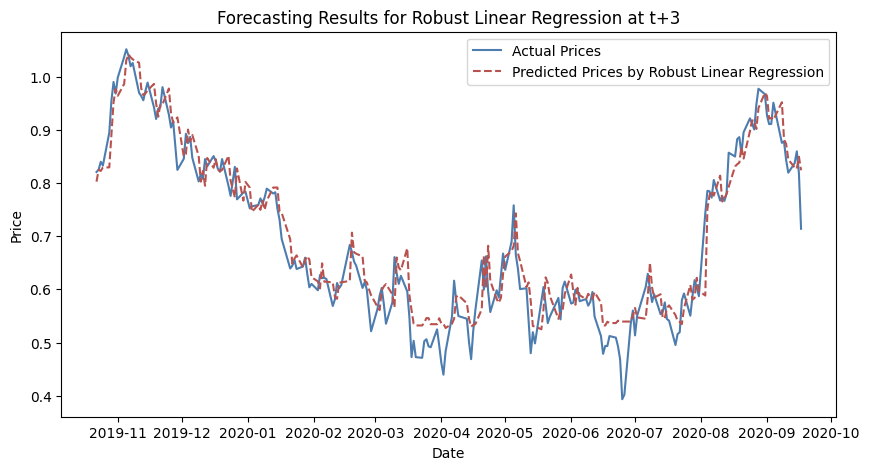

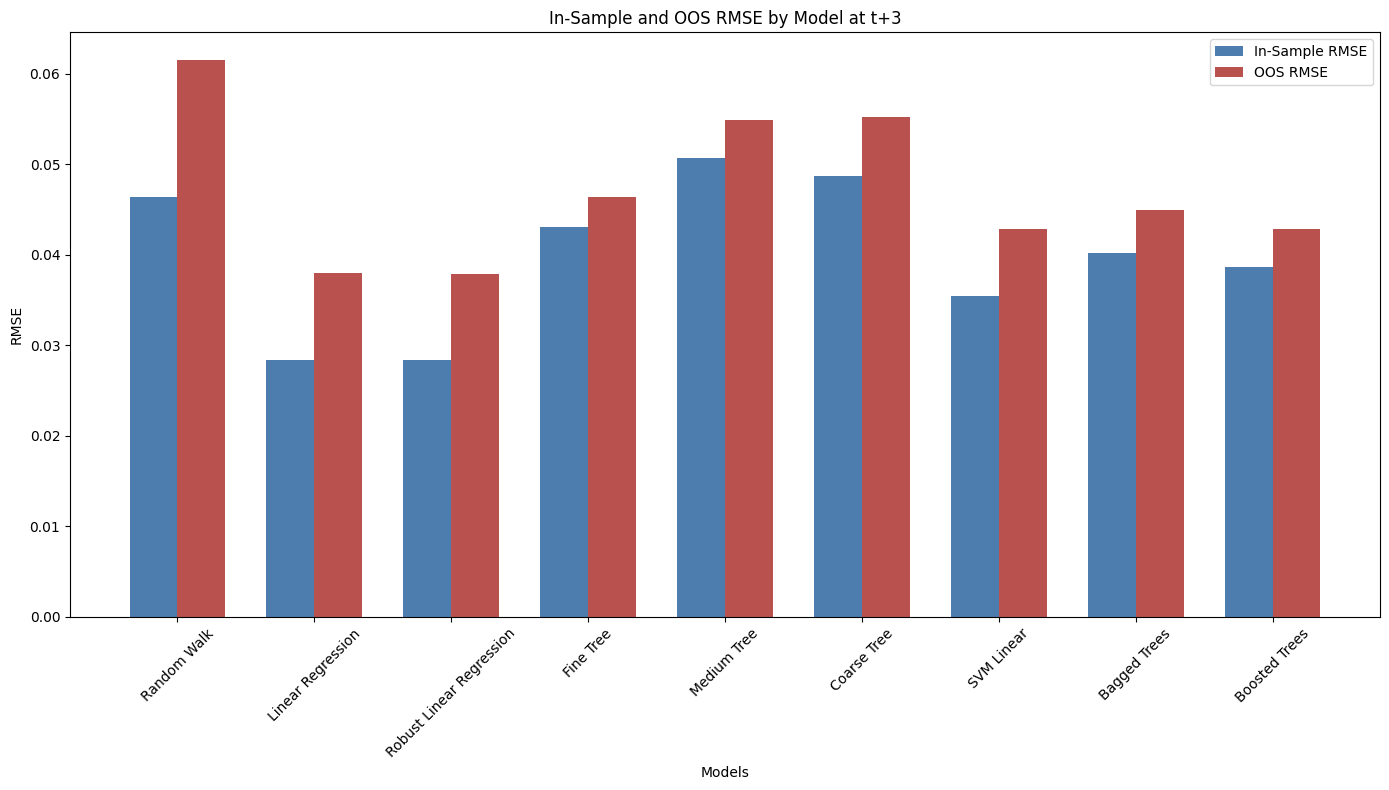

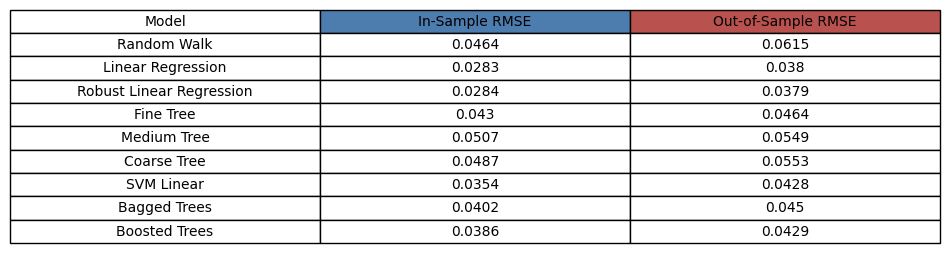


In-Sample RMSE Scores in Ascending Order:
                      Model  In-Sample RMSE
1         Linear Regression        0.028151
2  Robust Linear Regression        0.028193
6                SVM Linear        0.034965
8             Boosted Trees        0.038547
7              Bagged Trees        0.039178
3                 Fine Tree        0.042573
4               Medium Tree        0.048281
5               Coarse Tree        0.049496
0               Random Walk        0.059283

Out-of-Sample RMSE Scores in Ascending Order:
                      Model  Out-of-Sample RMSE
2  Robust Linear Regression            0.038064
1         Linear Regression            0.038172
8             Boosted Trees            0.042705
6                SVM Linear            0.042976
7              Bagged Trees            0.045702
3                 Fine Tree            0.046538
4               Medium Tree            0.056042
5               Coarse Tree            0.057372
0               Random Walk           

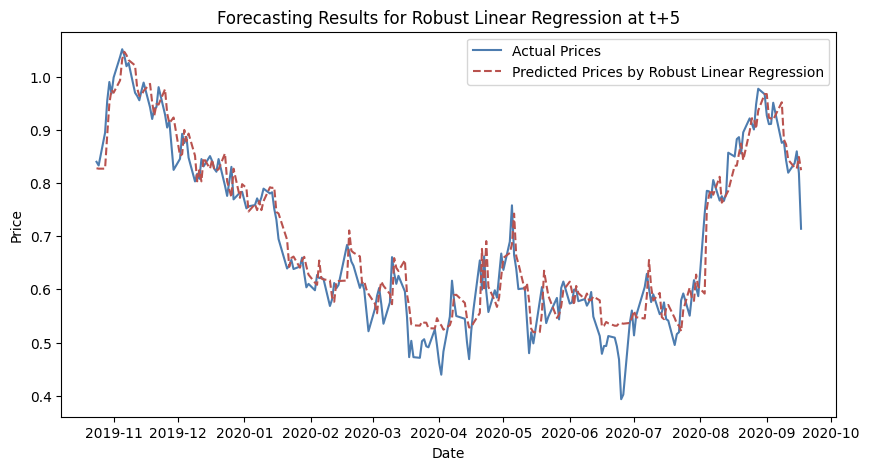

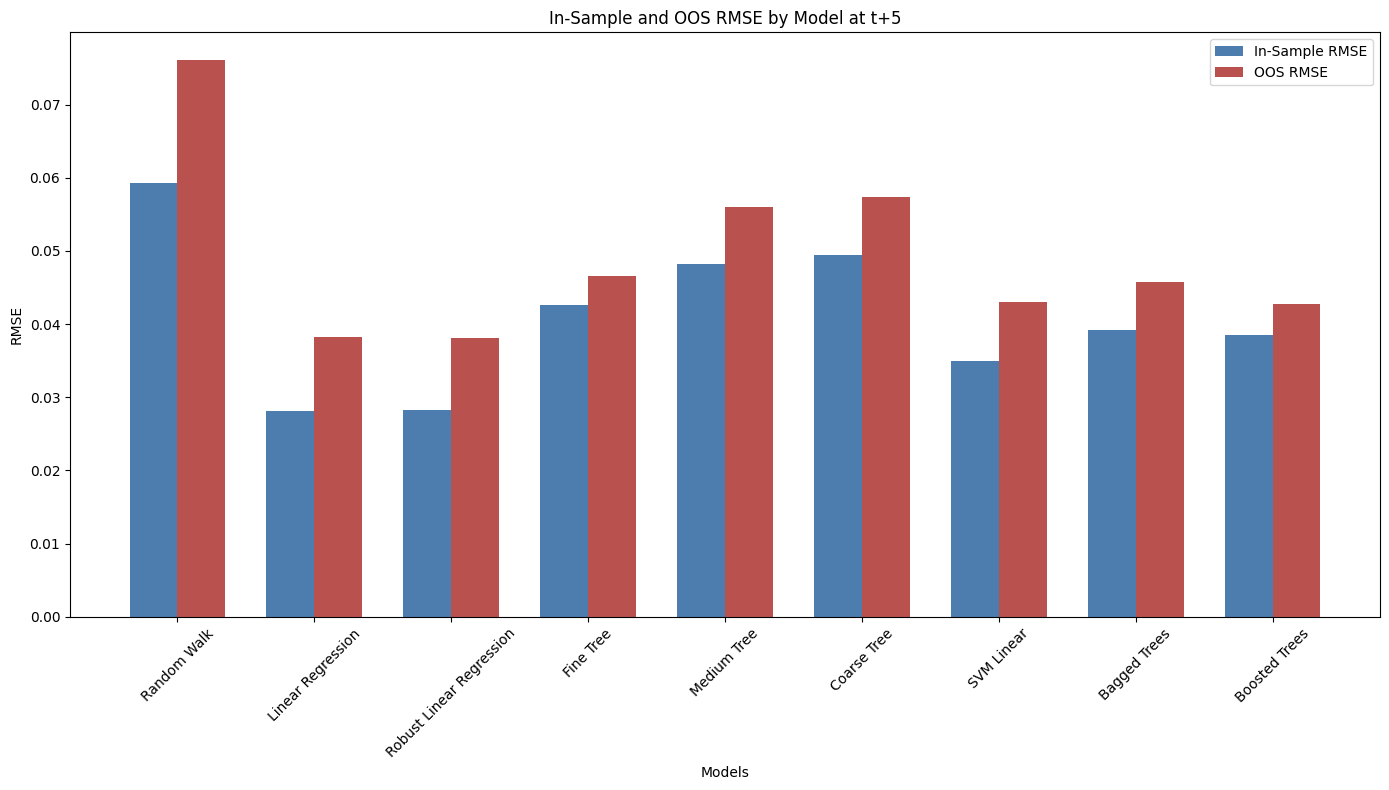

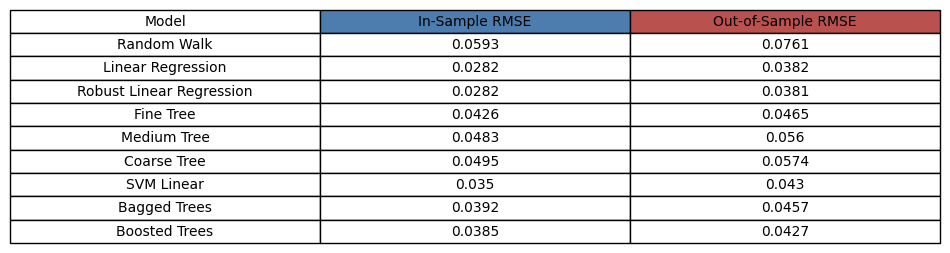


In-Sample RMSE Scores in Ascending Order:
                      Model  In-Sample RMSE
1         Linear Regression        0.028140
2  Robust Linear Regression        0.028187
6                SVM Linear        0.035462
8             Boosted Trees        0.038763
7              Bagged Trees        0.039234
3                 Fine Tree        0.040598
4               Medium Tree        0.048257
5               Coarse Tree        0.049410
0               Random Walk        0.082163

Out-of-Sample RMSE Scores in Ascending Order:
                      Model  Out-of-Sample RMSE
2  Robust Linear Regression            0.037977
1         Linear Regression            0.038090
8             Boosted Trees            0.041507
6                SVM Linear            0.043197
7              Bagged Trees            0.045092
3                 Fine Tree            0.046662
5               Coarse Tree            0.053418
4               Medium Tree            0.056650
0               Random Walk           

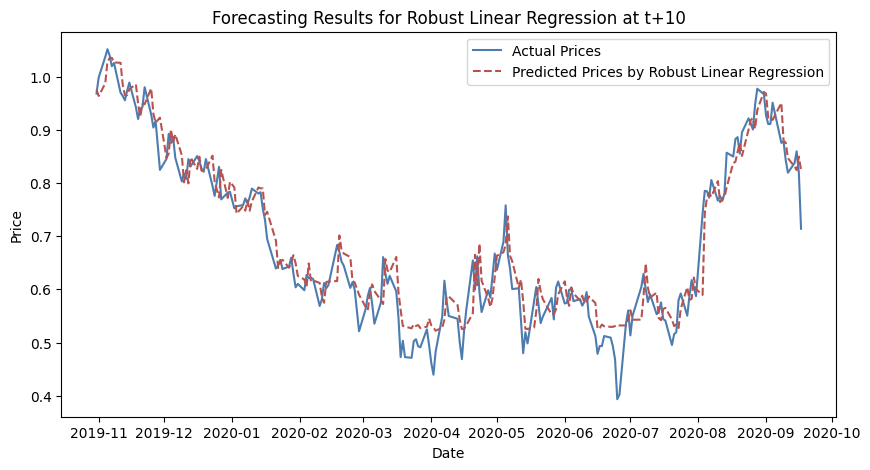

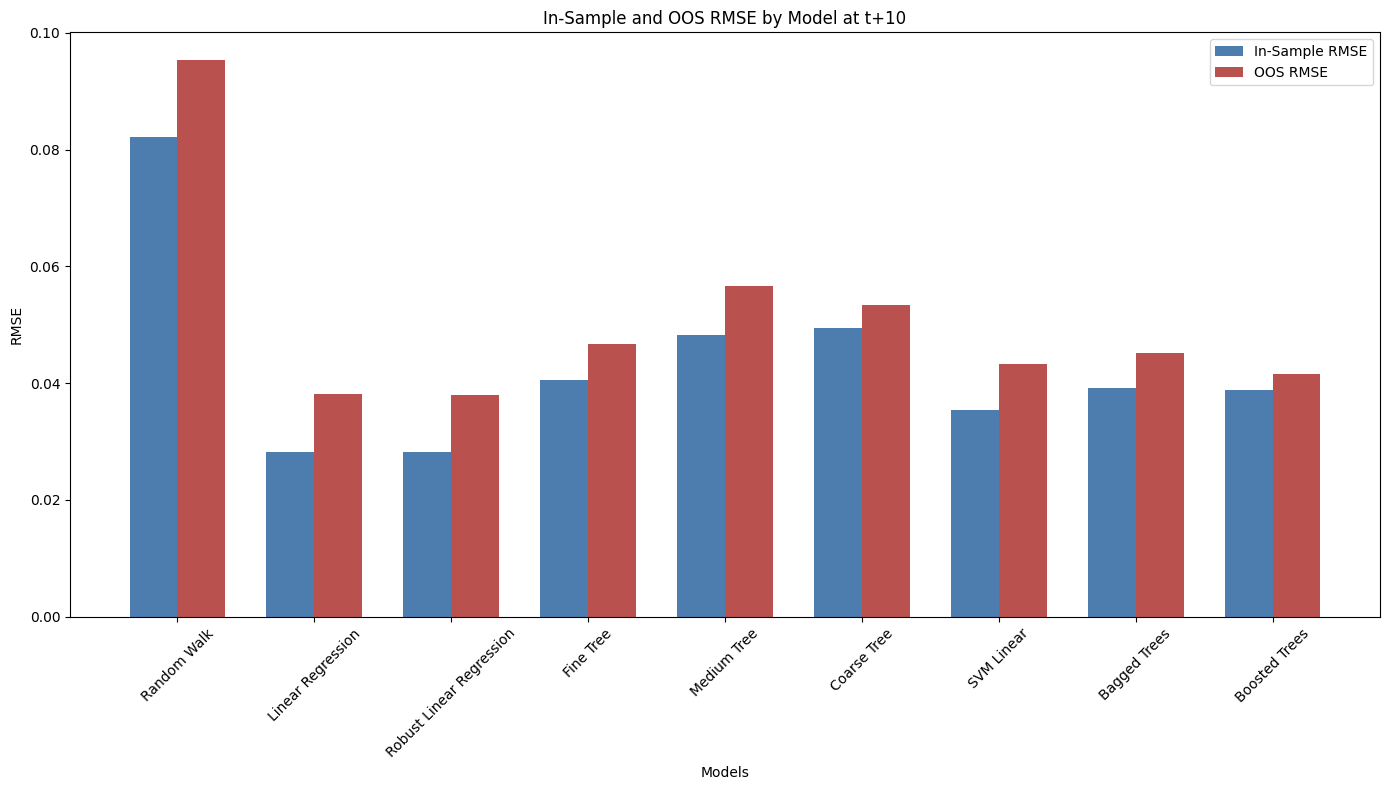

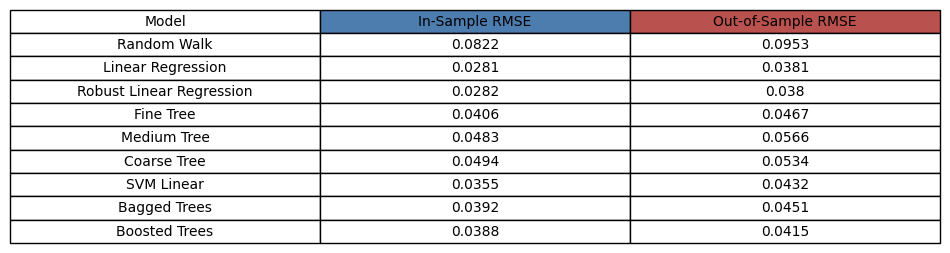

In [41]:
model_results = []
time_horizons = [3, 5, 10]

for shift in time_horizons:
    X_train_shifted, y_train_shifted = prepare_data(X_train_scaled, y_train, shift)
    X_test_shifted, y_test_shifted = prepare_data(X_test_scaled, y_test, shift)

    results_by_model = []

    for name, model in models.items():
        if model is not None:
            scores = cross_val_score(model, X_train_shifted, y_train_shifted, cv=TimeSeriesSplit(n_splits=5), scoring=rmse_scorer)
            model.fit(X_train_shifted, y_train_shifted)
            y_pred = model.predict(X_test_shifted)

            in_sample_rmse = -scores.mean()
            out_sample_rmse = rmse_score(y_test_shifted, y_pred)

            results_by_model.append({
                'Model': name,
                'In-Sample RMSE': in_sample_rmse,
                'Out-of-Sample RMSE': out_sample_rmse
            })
        else:
            if name == 'Random Walk':
                y_pred_in_sample = np.roll(y_train_shifted, shift)
                y_pred_in_sample[:shift] = y_train_shifted[0]  # Handle the first 'shift' elements
                in_sample_rmse = rmse_score(y_train_shifted, y_pred_in_sample)

                y_pred_out_sample = np.roll(y_test_shifted, shift)
                y_pred_out_sample[:shift] = y_test_shifted[0]  # Handle the first 'shift' elements
                out_sample_rmse = rmse_score(y_test_shifted, y_pred_out_sample)

                results_by_model.append({
                    'Model': name,
                    'In-Sample RMSE': in_sample_rmse,
                    'Out-of-Sample RMSE': out_sample_rmse
                })

    results_df_shift = pd.DataFrame(results_by_model)

    best_in_sample_model = results_df_shift.loc[results_df_shift['In-Sample RMSE'].idxmin()]
    best_out_sample_model = results_df_shift.loc[results_df_shift['Out-of-Sample RMSE'].idxmin()]


    print("\nIn-Sample RMSE Scores in Ascending Order:")
    print(results_df_shift[['Model', 'In-Sample RMSE']].sort_values(by='In-Sample RMSE'))

    print("\nOut-of-Sample RMSE Scores in Ascending Order:")
    print(results_df_shift[['Model', 'Out-of-Sample RMSE']].sort_values(by='Out-of-Sample RMSE'))

    print(f"Results for t+{shift}:")
    print(f"Best In-Sample Model: {best_in_sample_model['Model']} with RMSE: {best_in_sample_model['In-Sample RMSE']:.4f}")
    print(f"Best Out-of-Sample Model: {best_out_sample_model['Model']} with RMSE: {best_out_sample_model['Out-of-Sample RMSE']:.4f}")

    if best_out_sample_model['Model']:
        plt.figure(figsize=(10, 5))
        plt.plot(y_test_shifted.index, y_test_shifted, label='Actual Prices', color='#4d7caf')
        plt.plot(y_test_shifted.index, y_pred, label='Predicted Prices by ' + best_out_sample_model['Model'], linestyle='--', color='#b9524e')
        plt.title(f'Forecasting Results for {best_out_sample_model["Model"]} at t+{shift}')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.show()

    x = np.arange(len(results_df_shift['Model']))
    width = 0.35

    fig, ax = plt.subplots(figsize=(14, 8))
    rects1 = ax.bar(x - width/2, results_df_shift['In-Sample RMSE'], width, label='In-Sample RMSE', color='#4d7caf')
    rects2 = ax.bar(x + width/2, results_df_shift['Out-of-Sample RMSE'], width, label='OOS RMSE', color='#b9524e')

    ax.set_xlabel('Models')
    ax.set_ylabel('RMSE')
    ax.set_title(f'In-Sample and OOS RMSE by Model at t+{shift}')
    ax.set_xticks(x)
    ax.set_xticklabels(results_df_shift['Model'], rotation=45)
    ax.legend()

    plt.tight_layout()
    plt.show()

    results_df_shift = results_df_shift.applymap(lambda x: round(x, 4) if isinstance(x, (float, int)) else x)
    fig, ax = plt.subplots(figsize=(12, 1))
    ax.axis('tight')
    ax.axis('off')
    the_table = ax.table(cellText=results_df_shift.values, colLabels=results_df_shift.columns, loc='center', cellLoc='center', colColours=['none', '#4d7caf', '#b9524e'])
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(10)
    the_table.scale(1, 1.4)
    plt.show()
